In [1]:
# import all required packages
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import mnist_reader
from IPython import display

In [2]:
train_imgs, train_label = mnist_reader.load_mnist('data/fashion', kind='train')
test_imgs, test_label = mnist_reader.load_mnist('data/fashion', kind='t10k')
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32')
train_imgs = (train_imgs - 127.5) / 127.5 # Normalize the images in between -1 and 1

BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [3]:
# Batch and Shuffle the data

train_set = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

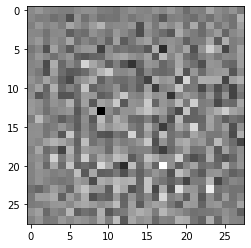

In [4]:
# Architecture for Generator

def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) #None refers to the batch size

    # Conv2DTranspose are used to upsample for generating an image from a seed which is random noise
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = generator_model()

noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0,:,:,0], cmap='gray')

In [5]:
# Architecture for Discriminator Model

def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
discriminator = discriminator_model()

decision_output = discriminator(generated_img)

print(decision_output)

tf.Tensor([[0.00162588]], shape=(1, 1), dtype=float32)


In [7]:
# compute CrossEntropyLoss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
# Define discriminator loss

def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
    return tot_loss

In [9]:
# Define Generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
# Defining separate optimizers for generator and discriminator
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
dis_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
checkpoints_dir = './training_chpk'
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer, dis_optimizer=dis_optimizer, generator=generator, discriminator=discriminator)

In [12]:
EPOCHS = 6

noise_dim = 100
num_ex_to_gen = 16

seed = tf.random.normal([num_ex_to_gen,noise_dim])

In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator(noise, training=True)

        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)

    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for img_batch in dataset:
            train_step(img_batch)

        #produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 12 EPOCHS
        if (epoch + 1) % 12 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generator after final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):

    # Training set to false so that every layer runs in inferenc mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

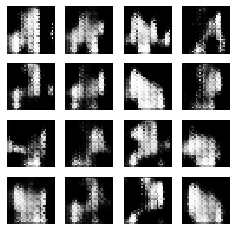

CPU times: user 3h 52min 33s, sys: 12min 44s, total: 4h 5min 17s
Wall time: 36min 41s


In [16]:
%%time
train(train_set, EPOCHS)

In [17]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir))

In [24]:
out_file = './image/fmdcgan.gif'

with imageio.get_writer(out_file, mode='I') as writer:
    filenames = glob.glob('./image/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

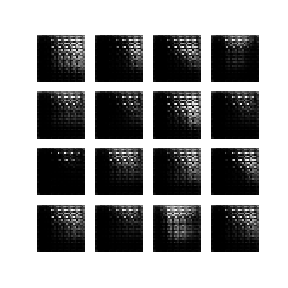

In [25]:
display.Image(filename=out_file)